In [14]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


You are now optimising six hyper-parameters of a machine learning model. Note that it is a popular and frequently used model, so maybe you could search to see if anyone else has optisized it before?

In [15]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_7/initial_inputs.npy',
    '../initial_data/function_7/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_7/initial_inputs.npy',
    '../initial_data2/function_7/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,x3,x4,x5,x6,y
0,0.272624,0.324495,0.897109,0.832951,0.154063,0.795864,0.604433
1,0.543003,0.924694,0.341567,0.646486,0.718440,0.343133,0.562753
2,0.090832,0.661529,0.065931,0.258577,0.963453,0.640265,0.007503
3,0.118867,0.615055,0.905816,0.855300,0.413631,0.585236,0.061424
4,0.630218,0.838097,0.680013,0.731895,0.526737,0.348429,0.273047


In [16]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f7', 'f7_output']]
df_feedback['f7'] = df_feedback['f7'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f7'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f7'].apply(lambda x: float(x[i]))

df_feedback.drop('f7', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f7_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,x3,x4,x5,x6,y
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.488711,0.463479,0.419242,0.574570,0.479240,0.468462,0.265990
std,0.298266,0.281422,0.300551,0.299678,0.287136,0.270783,0.415290
min,0.011732,0.011813,0.003635,0.073659,0.002492,0.008243,0.000422
25%,0.238300,0.227037,0.140328,0.309239,0.258221,0.243005,0.016334
50%,0.476823,0.477865,0.378440,0.616511,0.487436,0.460503,0.076043
75%,0.729331,0.661424,0.665817,0.835260,0.718908,0.713322,0.370941
max,0.999999,0.977801,0.996856,0.999999,0.998655,0.951014,2.114691


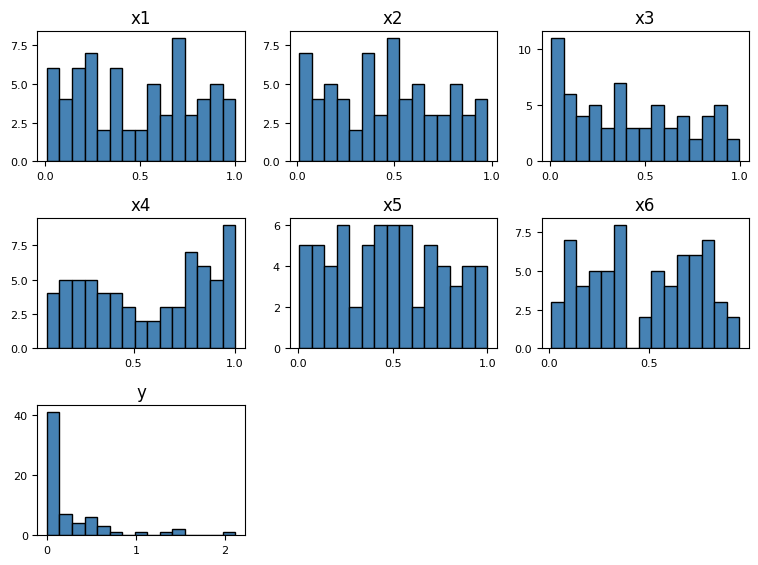

In [17]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [18]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


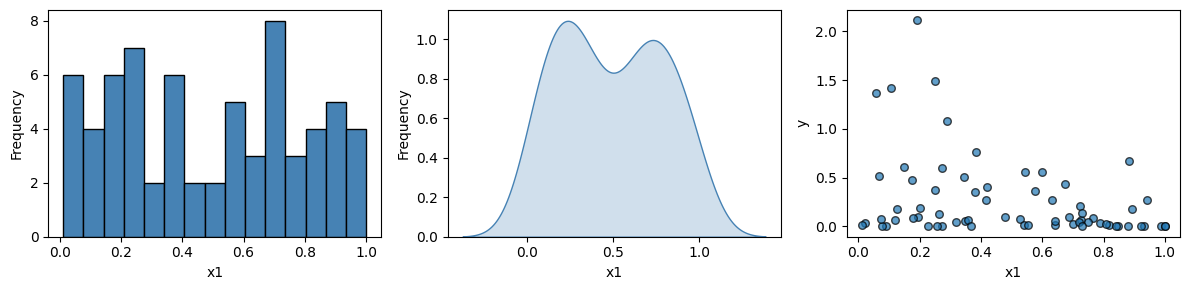

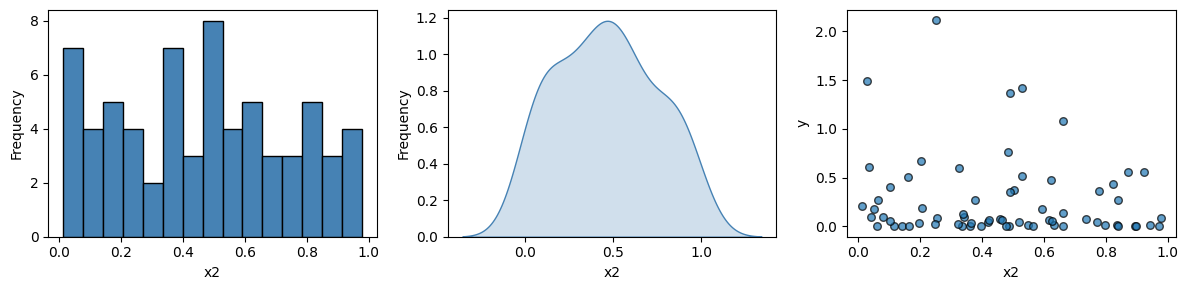

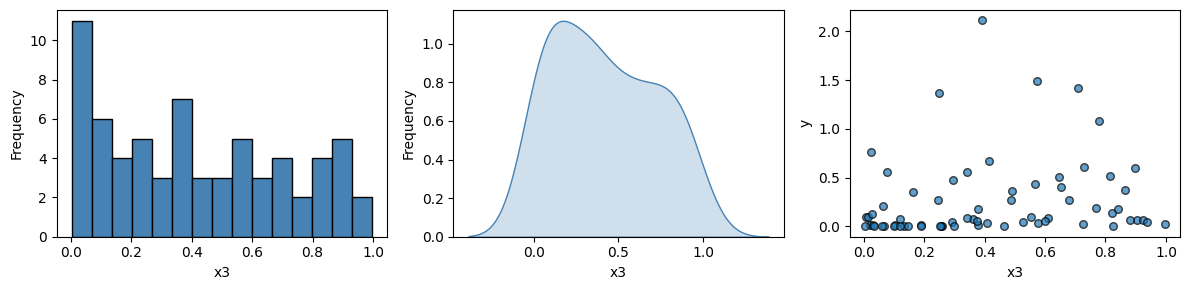

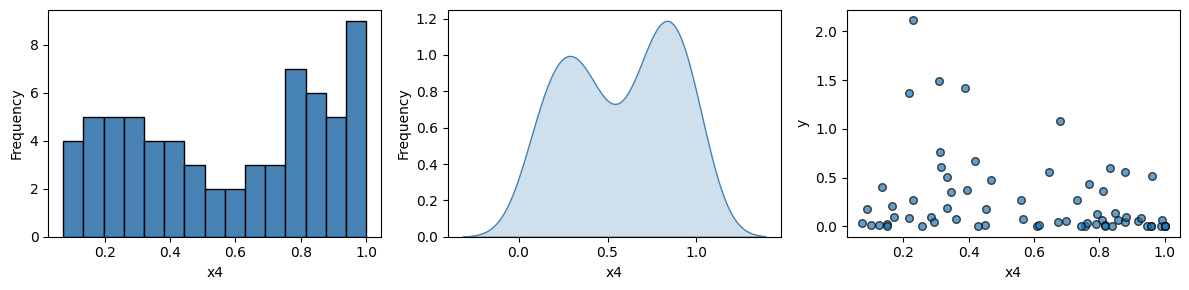

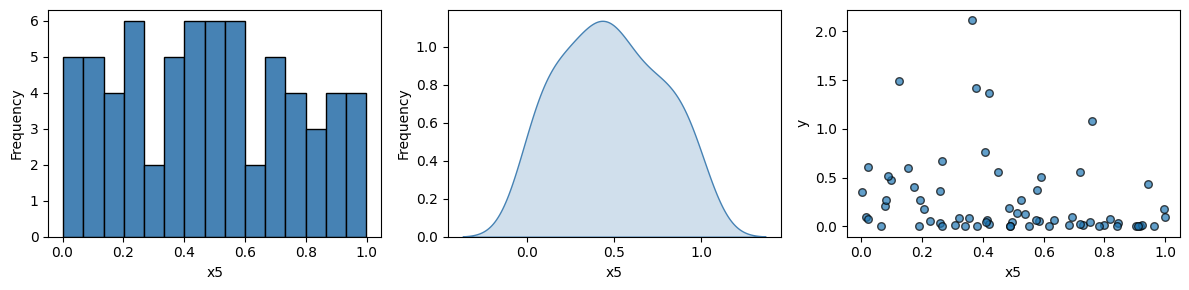

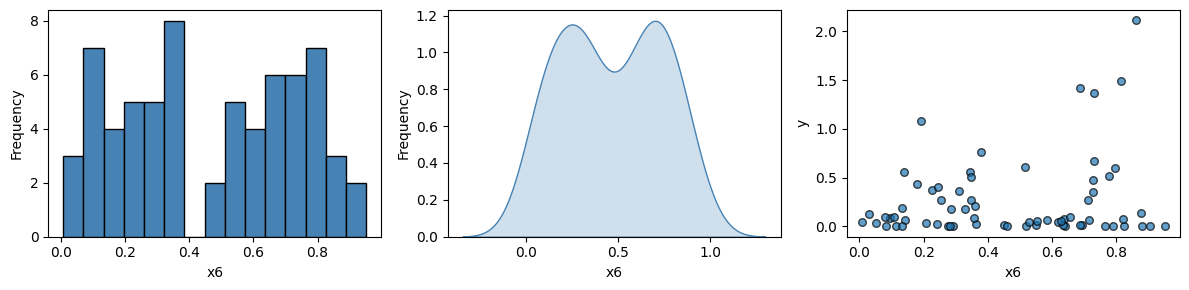

In [19]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')
analyse_param(df, 'x3', 'y')
analyse_param(df, 'x4', 'y')
analyse_param(df, 'x5', 'y')
analyse_param(df, 'x6', 'y')


In [20]:
def analyse_corr_to_y(df):
    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm')

    # Analyse correlation of variables to y
    g = sns.PairGrid(df, y_vars=["y"], x_vars=["x1", "x2", "x3", "x4", "x5", "x6"])
    g.map(sns.regplot, color='steelblue')

    plt.tight_layout()
    plt.show()

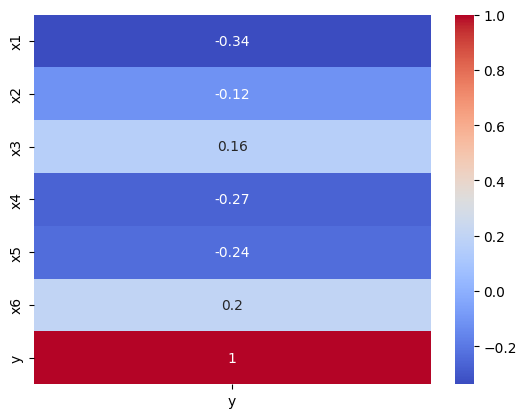

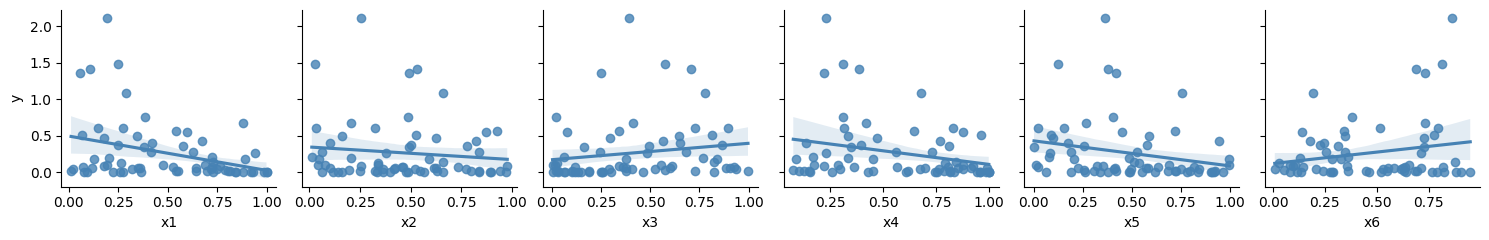

In [21]:
analyse_corr_to_y(df)

In [22]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

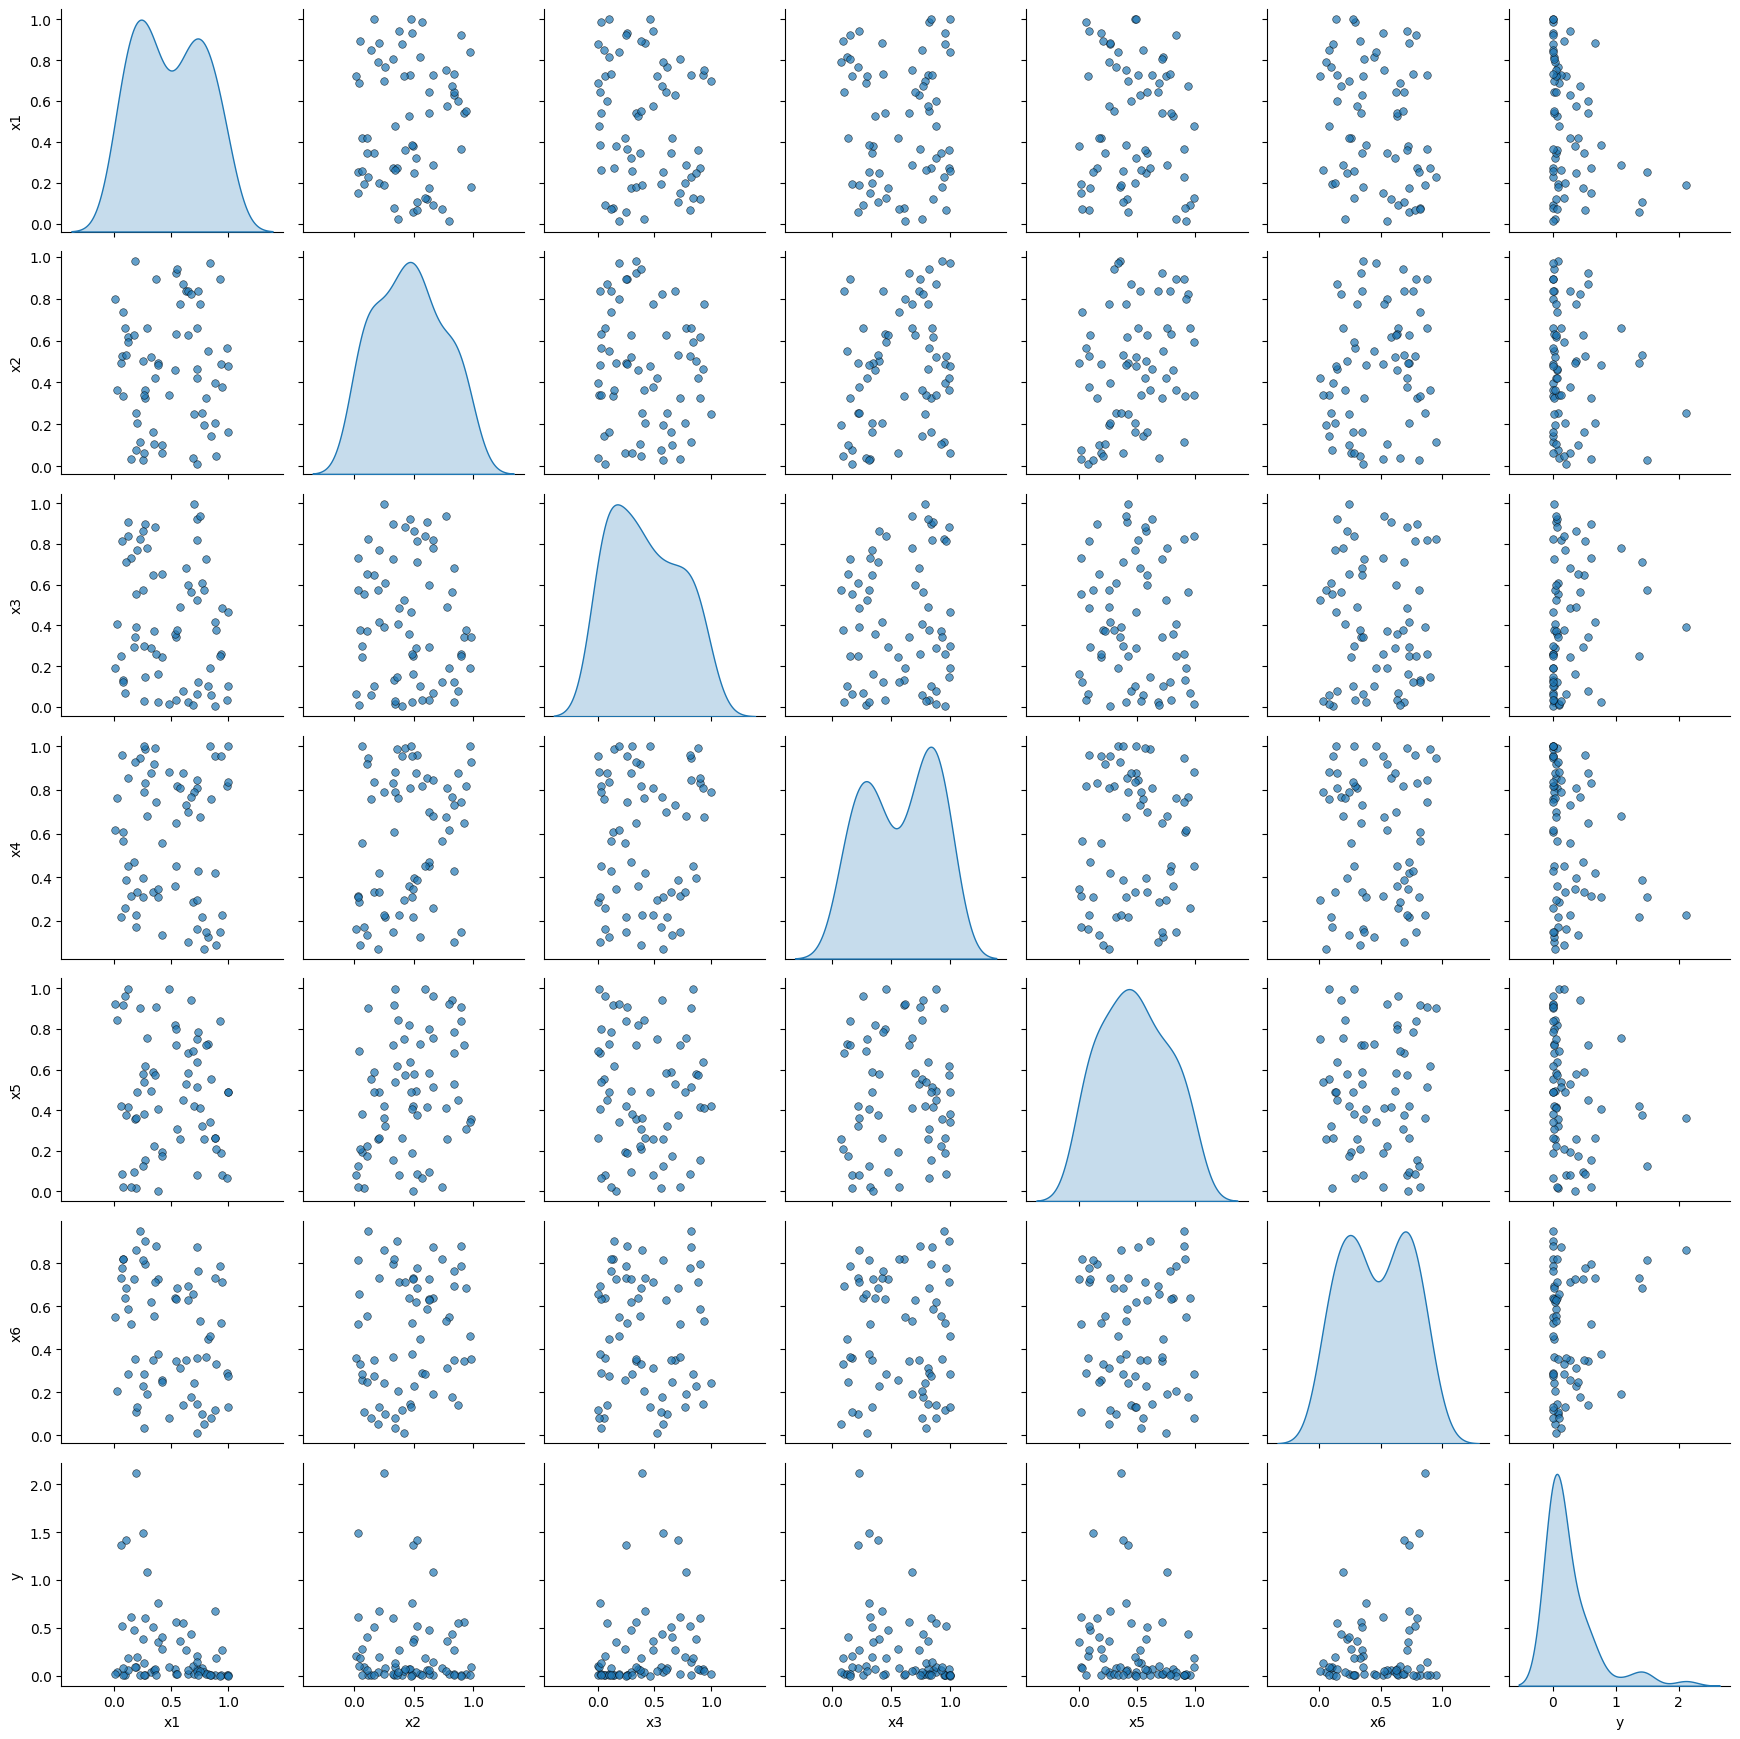

In [23]:
pairwise_relationship(df)

In [24]:
def objective_fn(x):
    return -(np.array([x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3] + x[:, 4] + x[:, 5]]).T)

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x4', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x5', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x6', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.RBF(
    input_dim=6,
    variance=1.0,
    lengthscale=1.0,
    ARD=True
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

In [25]:
bo.plot_acquisition()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
